# CS342 Project: Bayes Classifiers, Calibration, and Multicalibration
Student ID: 2209121

## Part A – Feature Extraction and Bayes Classifier

### Part A.1

#### A.1.1 — Load Embeddings and CelebA Attributes

**Goal of this section:**  
Load the ViT embedding vectors and the CelebA attribute table. These provide the feature matrix \(X\) and the attribute labels used later for classification.

**What this code does:**  
- Loads the pre-computed ViT embeddings from a `.npy` file.  
- Loads the CelebA attribute annotations from `list_attr_celeba.txt`.  

In [1]:
import numpy as np
import pandas as pd

# Load ViT embeddings (X)
X = np.load("celeba_sampled_attributes.npz")["embeddings"]
#print("Embeddings shape:", X.shape)

# Load & read CelebA attributes file
attr_path = "../data/list_attr_celeba.txt"
attr = pd.read_csv(attr_path, sep='\s+', skiprows=1)

#print("Attributes shape (full file):", attr.shape)

# View first five rows of table
#attr.head() 


<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
C:\Users\rshie\AppData\Local\Temp\ipykernel_35724\1291076996.py:10: SyntaxWarning: invalid escape sequence '\s'
  attr = pd.read_csv(attr_path, sep='\s+', skiprows=1)
C:\Users\rshie\AppData\Local\Temp\ipykernel_35724\1291076996.py:10: SyntaxWarning: invalid escape sequence '\s'
  attr = pd.read_csv(attr_path, sep='\s+', skiprows=1)


FileNotFoundError: [Errno 2] No such file or directory: 'celeba_sampled_attributes.npz'

#### A.1.2 – Align & Extract Labels

**Goal of this section:**  
Align the attribute table with the selected ViT embeddings and extract the *Smiling* labels to form the target vector **y**.

**What the code does:**  
- Selects the same rows from the attribute table as the embeddings.  
- Extracts the `"Smiling"` column.  
- Converts labels from **–1/+1** to **0/1** so that they are suitable for binary classification.

In [ ]:
# Select the first 20,000 attribute rows to align with X
attr_sub = attr.iloc[:20000].copy()

print("Subset attribute shape:", attr_sub.shape)
attr_sub.head()

# Extract raw Smiling labels
y_raw = attr_sub["Smiling"].values

# Convert from -1/+1 → 0/1
y = (y_raw == 1).astype(int)

print("y shape:", y.shape)
print("Unique values in y:", np.unique(y))


Subset attribute shape: (20000, 40)
y shape: (20000,)
Unique values in y: [0 1]


#### A.1.3 – Train/Calibration/Test Split

**Goal of this section:**  
Partition the aligned samples into the following disjoint subsets:
- **Training set:** 70% (14,000 samples)  
- **Calibration set:** 15% (3,000 samples)  
- **Test set:** 15% (3,000 samples)

**What this code does:**  
- Randomly shuffles the 20,000 sample indices (with a fixed seed for reproducibility).  
- Computes the exact split sizes.  
- Extracts the corresponding samples from X and y to form `X_train`, `X_cal`, `X_test` and their matching labels.  

In [ ]:
# Ensure reproducibility of split
np.random.seed(42)

n = X.shape[0]  # 20000
indices = np.random.permutation(n)

# Compute split sizes
n_train = int(0.70 * n)         # 14000
n_cal   = int(0.15 * n)         # 3000
n_test  = n - n_train - n_cal   # 3000

# Split indices
train_idx = indices[:n_train]
cal_idx   = indices[n_train:n_train + n_cal]
test_idx  = indices[n_train + n_cal:]

# Create datasets
X_train, y_train = X[train_idx], y[train_idx]
X_cal,   y_cal   = X[cal_idx],   y[cal_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

# Check shapes
print("Train:", X_train.shape, y_train.shape)
print("Calibration:", X_cal.shape, y_cal.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (14000, 768) (14000,)
Calibration: (3000, 768) (3000,)
Test: (3000, 768) (3000,)


### Part A.2

#### A.2.1 – Implement Gaussian Naive Bayes

**Goal of this section:**  
Implement a Gaussian Naive Bayes classifier to predict whether a face is Smiling (1) or Not Smiling (0).  The model assumes that each feature dimension is conditionally independent given the class label and follows a Gaussian distribution:
$ X_j \mid y=c \sim \mathcal{N}(\mu_{c,j},\; \sigma^2_{c,j}) $

**What this code does:**  
This section defines the Gaussian Naive Bayes classifier as a class. It implements the the following functionality:

- **`fit(X, y)`** - Estimates per-class feature means, variances, and class priors from the training set  
- **`_gaussian_logpdf(x, mean, var)`** - Computes the per-feature log of the Gaussian density function, used when when calculating class log-likelihoods.
- **`predict(X)`** Computes log-posteriors for each class and returns the most likely class label for each sample.  
- **`predict_proba(X)`** Applies a softmax over log-posteriors to convert them into class probabilities for each sample.

In [ ]:
import numpy as np

class NaiveBayesClassifier:
    """
    Gaussian Naive Bayes classifier.
    Models each feature as N(mean, variance) conditioned on y.
    """

    def fit(self, X, y):
        """
        Fit the Naive Bayes model.
        X : (n_samples, n_features)
        y : (n_samples,)
        """

        # Identify all unique class labels in y and determine feature dimensions
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]

        # Storage initialisation for per-class feature means, variances and prior probability
        self.means = np.zeros((n_classes, n_features))
        self.vars  = np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)

        # For each class c: gather all samples with label c, then compute the per-feature mean, per-feature variance (with small smoothing), and the class prior P(y=c).
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.means[idx] = X_c.mean(axis=0)
            self.vars[idx]  = X_c.var(axis=0) + 1e-6   # Smoothing term to avoid zero variance
            self.priors[idx] = len(X_c) / len(X)

    def _gaussian_logpdf(self, x, mean, var):
        """
        Compute the log of the Gaussian probability density for each feature in X.
        """
        return -0.5 * (np.log(2*np.pi*var) + ((x - mean)**2) / var)

    def predict(self, X):
        """
        Predict class labels for X.
        """
        # Store log-posterior scores for each class (one array per class)
        log_posteriors = []

        # Loop over each class (idx indexes class 0 or 1, c is the class label)
        for idx, c in enumerate(self.classes):

            # Retrieve pre-computed Gaussian params (mean & variance) and log-prior for the current class c
            mean = self.means[idx]
            var  = self.vars[idx]
            prior = np.log(self.priors[idx])

            # Compute combined log-likelihood for every sample
            log_likelihood = np.sum(self._gaussian_logpdf(X, mean, var), axis=1)

            # Sum the log-likelihood & log-prior probability to get the log-posterior
            log_posterior = log_likelihood + prior

            log_posteriors.append(log_posterior)

        # Stack arrays into a matrix and transpose: each row represents a sample and its score for each class
        log_posteriors = np.vstack(log_posteriors).T

        # For each sample, select the class index that corresponds to the maximum log-posterior score
        return np.argmax(log_posteriors, axis=1)
    
    def predict_proba(self, X):
        """
        Return class probabilities P(y=c | x) for each sample x.
        """
        # Store log-posterior scores for each class (one array per class)
        log_posteriors = []

        # Loop over each class (idx indexes class 0 or 1, c is the class label)
        for idx in range(len(self.classes)):

            # Retrieve pre-computed Gaussian params (mean & variance) and log-prior for the current class c
            mean = self.means[idx]
            var  = self.vars[idx]
            prior = np.log(self.priors[idx])

            # Compute combined log-likelihood for every sample
            log_likelihood = np.sum(self._gaussian_logpdf(X, mean, var), axis=1)

            # Sum the log-likelihood & log-prior probability to get the log-posterior
            log_posterior = log_likelihood + prior

            log_posteriors.append(log_posterior)

        # Convert the list of score arrays into a matrix (n_classes x n_samples)
        log_posteriors = np.vstack(log_posteriors)

        # Softmax over classes
        # Find the max log-posterior across classes for each sample
        max_log = np.max(log_posteriors, axis=0, keepdims=True)

        # Compute the exponentiated scores, subtracting max score to prevent overflow
        exp_scores = np.exp(log_posteriors - max_log)

        # Calculate probabilities by dividing exp_scores by the sum of all exp_scores across classes, as required by the softmax operation
        probs = exp_scores / np.sum(exp_scores, axis=0, keepdims=True)

        # Transpose probability matrix: each row represents a sample and its probabilities for each class
        return probs.T

#### A.2.2 – Train Naive Bayes and Report Test Accuracy

**Goal of this section:**  
Train the implemented Gaussian Naive Bayes classifier on the training set and evaluate its predictive performance on the test set.

**What this code does:**
- Initialises a `NaiveBayesClassifier` instance  
- Fits the model on the training split $(X_{\text{train}}, y_{\text{train}})$  
- Predicts class labels for the test split $X_{\text{test}}$
- Computes the test accuracy using: $\text{accuracy} = \frac{\text{number of correct predictions}}{\text{total number of test samples}}$

- Outputs the accuracy score

In [ ]:
# Create classifier instance
nb = NaiveBayesClassifier()

# Fit model on the training split
nb.fit(X_train, y_train)

# Predict on the test split
y_pred = nb.predict(X_test)

# Compute accuracy and display
test_accuracy = np.mean(y_pred == y_test)
print(f"Naive Bayes test accuracy on 'Smiling': {test_accuracy:.4f}")

Naive Bayes test accuracy on 'Smiling': 0.7363


## Part B – Population Calibration

### Part B.1

#### B.1 – Compute Predicted Probabilities and Plot Reliability Diagram

**Goal of this section:**  
Estimate predicted probabilities $ \hat{p}(x) $ for all samples in the calibration set, then visualise how well-calibrated the Naive Bayes model is using a reliability diagram.

**What this code does:**
- Calls `predict_proba` to compute class probabilities for the calibration samples
- Uses the calibration split $(X_{\text{cal}}, y_{\text{cal}})$ to compute predicted probabilities for the *Smiling* class  
- Bins the predictions into fixed intervals (10 bins from 0-1)  
- Computes for each bin:
  - Average predicted probability
  - Actual fraction of smiling images  
- Plots these values on a reliability diagram, comparing confidence to true outcomes

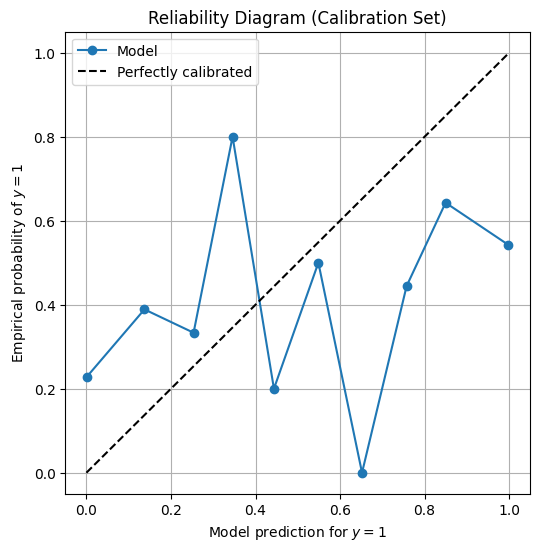

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract predicted probabilities that each calibration sample is smiling (class 1)
cal_probs = nb.predict_proba(X_cal)[:, 1]  
cal_true = y_cal

# Define probability bins
n_bins = 10
bins = np.linspace(0, 1, n_bins + 1)

# Assign each predicted probability to one of the bin intervals
bin_indices = np.digitize(cal_probs, bins) - 1

# Store per-bin average predicted probabilities and fraction of true positives
avg_pred = []
frac_true = []

# For each bin, compute statistics
for b in range(n_bins):

    # Boolean mask selecting all samples whose predicted prob falls in bin b
    in_bin = (bin_indices == b)

    # If no samples in bin
    if np.sum(in_bin) == 0:
        avg_pred.append(np.nan)
        frac_true.append(np.nan)
        continue    # Skip
    
    # Store stats
    avg_pred.append(np.mean(cal_probs[in_bin]))
    frac_true.append(np.mean(cal_true[in_bin]))

# Convert to arrays for plotting
avg_pred = np.array(avg_pred)
frac_true = np.array(frac_true)

# Plot reliability diagram
plt.figure(figsize=(6,6))
plt.plot(avg_pred, frac_true, marker='o', label="Model")
plt.plot([0,1],[0,1], 'k--', label="Perfectly calibrated")
plt.xlabel("Model prediction for $y = 1$")
plt.ylabel("Empirical probability of $y = 1$")
plt.title("Reliability Diagram (Calibration Set)")
plt.legend()
plt.grid(True)
plt.show()

### Part B.2

#### B.2.1 – Compute Calibration Errors

**Goal of this section:**  
Evaluate how well-calibrated the Naive Bayes model is on the test set, using:

- **MSE (Mean Squared Error):**  Measures how close predicted probabilities are to the true labels.

- **ECE (Expected Calibration Error):**  Measures the mismatch between predicted confidence and empirical accuracy across probability bins.

**What this code does:**
- Calls `predict_proba` to compute class probabilities for the test samples
- Computes **MSE**  
- Computes **ECE** using the defined probability bins 
- Reports both scores. If predicted probabilities are:
  - *higher* than true fractions → model is **overconfident**  
  - *lower* than true fractions → model is **underconfident**

In [ ]:
# Extract predicted probabilities that each test sample is smiling (class 1)
test_probs = nb.predict_proba(X_test)[:, 1]
test_true  = y_test

# Compute MSE
mse = np.mean((test_probs - test_true)**2)

# Compute ECE
# Define probability bins
n_bins = 10
bins = np.linspace(0, 1, n_bins + 1)

# Assign each predicted probability to one of the bin intervals
bin_indices = np.digitize(cal_probs, bins) - 1

ece = 0.0
N = len(test_probs)

# For each bin, compute its calibration error contribution
for b in range(n_bins):

    # Boolean mask selecting all samples whose predicted prob falls in bin b
    in_bin = (bin_indices == b)
    n_b = np.sum(in_bin)

    # If bin contains samples
    if n_b > 0:

        # Mean predicted probability for samples in bin b
        avg_pred_b = np.mean(test_probs[in_bin])

        # Empirical fraction of true positives in bin b
        frac_true_b = np.mean(test_true[in_bin])

        # Weighted contribution of this bin to ECE
        ece += (n_b / N) * abs(avg_pred_b - frac_true_b)

print(f"MSE on test set: {mse:.4f}")
print(f"ECE on test set: {ece:.4f}")

MSE on test set: 0.2563
ECE on test set: 0.0412


#### B.2.2 – Calibration Error Summary and Interpretation

| Metric | Score | Interpretation |
|-------|--------|----------------|
| **Mean Squared Error (MSE)** | **0.2563** | This is a moderate MSE value, reflecting a significant overall difference between the predicted probabilities, $ \hat{p}(x) $, and the true binary labels, $ y $. This is expected for a simple Naive Bayes model applied to high-dimensional features. |
| **Expected Calibration Error (ECE)** | **0.0412** | This is a low ECE value. It indicates that, when predictions are grouped, the model’s confidence levels are reasonably well aligned with the true outcomes. |

Overall, the reliability diagram shows significant variability across bins, but the majority of points lie below the perfect-calibration line. This means the model’s predicted probabilities tend to be slightly lower than the true fractions – i.e., **the model is mildly underconfident**.



## Part C – Subgroup Calibration

### Part C.1

#### C.1.1 – Define Helper Functions for Subgroup Calibration

**Goal of this section:**  
Define helper functions to compute calibration metrics and reliability diagrams for dataset subgroups.

**What this code does:**  
This section defines four helper functions:
- **`compute_ece(probs, true)`** – Computes the ECE.
- **`compute_mse(probs, true)`** – Computes the MSE between predicted probabilities and binary ground-truth labels.
- **`compute_accuracy(pred_labels, true)`** – Calculates the proportion of correctly predicted labels in a subgroup.
- **`plot_reliability(probs, true, title)`** – Generates a reliability diagram for a subgroup by plotting the average predicted probability against the empirical fraction of positives across bins.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_ece(probs, true, n_bins=10):
    """ 
    Compute the ECE for a subgroup
    """
    # Define probability bins
    bins = np.linspace(0, 1, n_bins + 1)

    # Assign each predicted proability to one of the bin intervals
    bin_ids = np.digitize(probs, bins) - 1

    ece = 0.0
    N = len(probs)

    # For each bin, compute its calibration error contribution
    for b in range(n_bins):

        # Boolean mask selecting all samples whose predicted prob falls in bin b
        in_bin = (bin_ids == b)
        n_b = np.sum(in_bin)

        # If bin contains samples
        if n_b > 0:

            # Mean predicted probability for samples in bin b
            avg_pred = np.mean(probs[in_bin])

            # Empirical fraction of true positives in bin b
            frac_true = np.mean(true[in_bin])

            # Weighted contribution of this bin to ECE
            ece += (n_b / N) * abs(avg_pred - frac_true)

    return ece


def compute_mse(probs, true):
    """
    Compute MSE for a subgroup
    """
    return np.mean((probs - true)**2)


def compute_accuracy(pred_labels, true):
    """
    Compute accuracy for a subgroup
    """
    return np.mean(pred_labels == true)


def plot_reliability(probs, true, title, n_bins=10):
    """
    Plot reliability diagram for a subgroup
    """

    # Define probability bins
    bins = np.linspace(0, 1, n_bins + 1)

    # Assign each predicted probability to one of the bin intervals
    bin_ids = np.digitize(probs, bins) - 1

    # Store per-bin average predicted probabilities and fraction of true positives
    avg_pred = []
    frac_true = []

    # For each bin compute statistics
    for b in range(n_bins):

        # Boolean mask selecting all samples whose predicted prob falls in bin b
        in_bin = (bin_ids == b)

        # If no samples in bin
        if np.sum(in_bin) == 0:
            avg_pred.append(np.nan)
            frac_true.append(np.nan)
            continue    # Skip
        
        # Store stats
        avg_pred.append(np.mean(probs[in_bin]))
        frac_true.append(np.mean(true[in_bin]))

    # Convert to arrays for plotting
    avg_pred = np.array(avg_pred)
    frac_true = np.array(frac_true)

    # Plot reliability diagram
    plt.figure(figsize=(5,5))
    plt.plot(avg_pred, frac_true, 'o-', label="Model")
    plt.plot([0,1],[0,1],'k--', label="Perfectly calibrated")
    plt.xlabel("Model prediction for $y = 1$")
    plt.ylabel("Empirical probability of $y = 1$")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

#### C.1.2 – Define Subgroups from CelebA Attributes

**Goal of this section:**  
Create boolean masks that identify the eight required subgroups in the test set, based on the CelebA attribute annotations. These masks allow us to extract subgroup-specific predictions in later steps.

**What this code does:**
- Selects the attribute rows corresponding to the test indices
- Constructs eight subgroup definitions using CelebA binary attributes:
  - Male / Female
  - Young / Not Young
  - Blond_Hair / Not Blond_Hair
  - Wearing_Hat / Not Wearing_Hat
- For each subgroup, a boolean mask is created indicating which test-set samples belong to it

In [ ]:
# Extract attribute columns only for test set
attr_test = attr_sub.iloc[test_idx]

# Define boolean mask for each subgroup in test set
subgroups = {
    "Male":               (attr_test["Male"] == 1),
    "Female":             (attr_test["Male"] == -1),
    "Young":              (attr_test["Young"] == 1),
    "Not_Young":          (attr_test["Young"] == -1),
    "Blond_Hair":         (attr_test["Blond_Hair"] == 1),
    "Not_Blond_Hair":     (attr_test["Blond_Hair"] == -1),
    "Wearing_Hat":        (attr_test["Wearing_Hat"] == 1),
    "Not_Wearing_Hat":    (attr_test["Wearing_Hat"] == -1),
}

#### C.1.3 – Compute Subgroup Metrics and Plot Reliability Diagrams

**Goal of this section:**  
Evaluate the calibration performance of the Naive Bayes model within each demographic subgroup.  
For every subgroup, we compute:

- Accuracy
- Mean Squared Error
- Expected Calibration Error
- A reliability diagram

**What this code does:**  
- Uses boolean masks (defined in C.1.2) to extract the test samples belonging to each subgroup  
- Computes subgroup-specific accuracy, MSE, and ECE using the helper functions from C.1.1  
- Plots a reliability diagram for each subgroup using `plot_reliability`  
- Saves all subgroup statistics into a results list

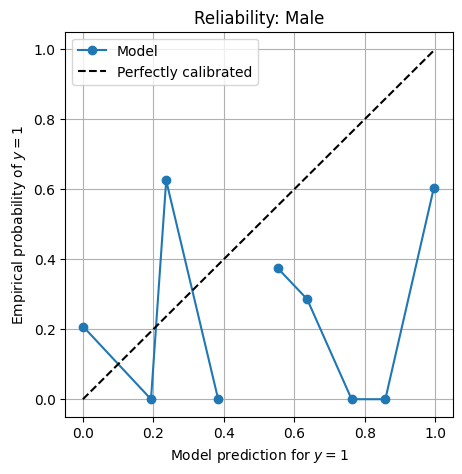

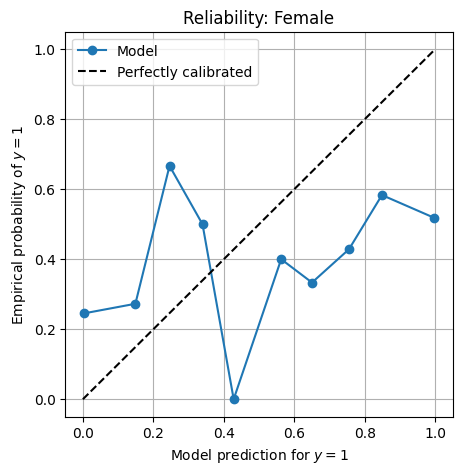

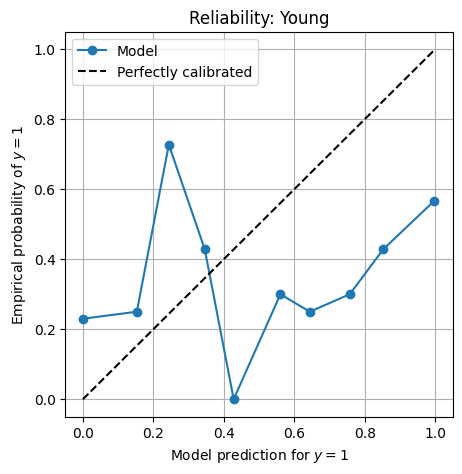

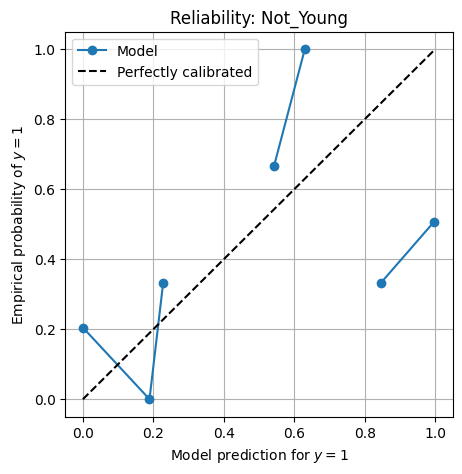

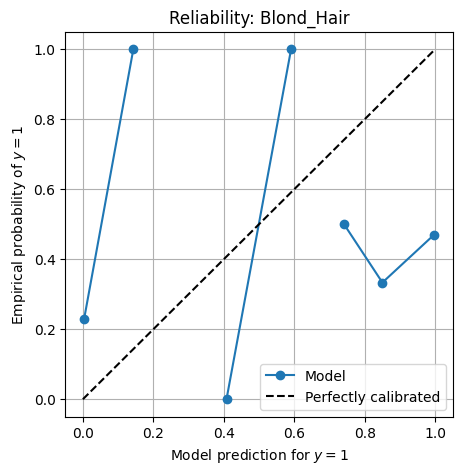

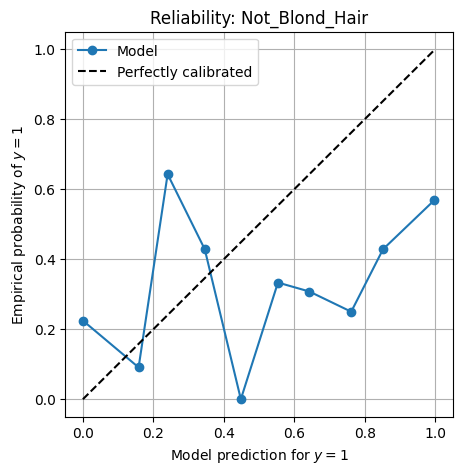

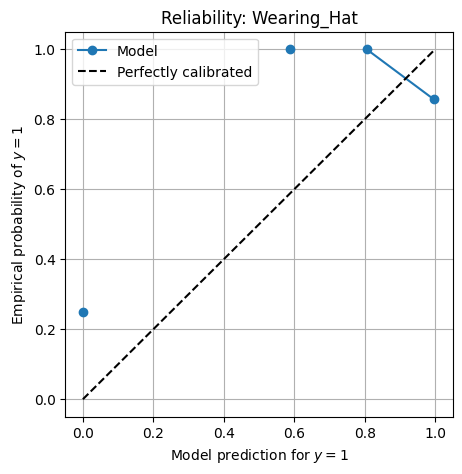

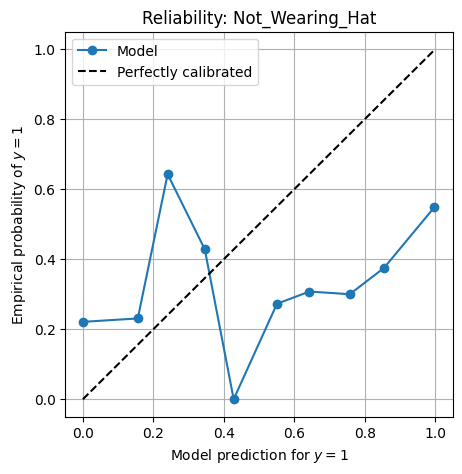

In [ ]:
# Store subgroup statistics
results = []

# Predicted probabilities for smiling on test set
test_probs = nb.predict_proba(X_test)[:, 1]
# Predicted labels on test set
test_pred  = nb.predict(X_test)

# For each subgroup evaluate calibration metrics
for name, mask in subgroups.items():

    # Select subgroup samples using the boolean mask
    probs_sg = test_probs[mask]
    true_sg  = y_test[mask]
    pred_sg  = test_pred[mask]
    size_sg  = len(true_sg)

    # Compute subgroup metrics
    mse_sg = compute_mse(probs_sg, true_sg)
    ece_sg = compute_ece(probs_sg, true_sg)
    acc_sg = compute_accuracy(pred_sg, true_sg)

    # Plot reliability diagram
    plot_reliability(probs_sg, true_sg, title=f"Reliability: {name}")

    results.append([name, size_sg, acc_sg, mse_sg, ece_sg])

#### C.1.4 – Summarise Subgroup Calibration Results

**Goal of this section:**  
Collect all subgroup metrics into a table for comparison.

**What this code does:**
- Converts the list of subgroup results into a pandas DataFrame
- Displays results in a table for analysis

In [ ]:
import pandas as pd

# Convert subgroup metrics into a DataFrame
df_results = pd.DataFrame(results, columns=[
    "Subgroup", "Size", "Accuracy", "MSE", "ECE"
])

# Display results
df_results

,Subgroup,Size,Accuracy,MSE,ECE
0,Male,1250,0.745600,0.245476,0.229311
1,Female,1750,0.729714,0.264008,0.206568
2,Young,2355,0.735881,0.255501,0.216322
3,Not_Young,645,0.737984,0.259153,0.215528
4,Blond_Hair,447,0.740492,0.257074,0.187371
5,Not_Blond_Hair,2553,0.735605,0.256148,0.221361
6,Wearing_Hat,162,0.765432,0.234907,0.239562
7,Not_Wearing_Hat,2838,0.734672,0.257507,0.214877


### Part C.2


#### **Least well-calibrated subgroups**
We use ECE to compare calibration across subgroups. Those with the highest ECE values are the least well calibrated:

| Subgroup | ECE |
|---------|---------|
| **Wearing_Hat** | **0.239** |
| **Male** | **0.229** |
| **Not_Blond_Hair** | **0.221** |
|...                |...        |              

The **Wearing_Hat** subgroup is the least well-calibrated subgroup, as clearly shown in its reliability diagram: 
- Across most populated bins (e.g., avg. predicted prob = 0.0, 0.6, 0.8), the model is strongly under-confident: the empirical success rate is much higher than the predicted probability. 
- At the highest bin (avg. predicted prob = 1.0), the model becomes over-confident, assigning full certainty despite the true success rate being closer to 85%. 

However, this extreme ECE value should be interpreted with caution, as the subgroup is very small (162 samples). Only a few bins contain data, which makes calibration metrics and the reliability curve much more sensitive to noise than in larger subgroups.

The Male and Not_Blond_Hair subgroups also show high ECE values, indicating similarly poor calibration. Their reliability diagrams show the model's confidence swings erratically across prediction bins, confirming that the calibration is not robust for these groups.

#### **Does overall calibration conceal subgroup differences?**

Yes. The overall calibration score hides huge subgroup variation.

The overall ECE on the test set is approximately $0.0412$, which suggests the model is relatively well-calibrated globally.

However, the subgroup results show:

- ECE for all subgroups is significantly worse, ranging from $0.187$ (Blond_Hair) to $0.240$ (Wearing_Hat). This means the best-calibrated subgroup is over four times worse than the overall ECE ($0.187 / 0.0412 \approx 4.54$). 
- Also, there is a wide spread of $0.052$ across subgroups, meaning the worst-calibrated subgroup is $\approx 28\%$ less calibrated than the best one.

This wide range shows that the model’s confidence estimates vary significantly across subgroups. A single global ECE would miss these discrepancies and imply that the model is well-calibrated, even though all examined subgroups exhibit substantially worse and more inconsistent calibration than the overall metric suggests.


## Part D – Improving Calibration and Multicalibration

### Part D.1

#### D.1.1 – Linear Calibration

**Goal of this section:**  
Apply a post-hoc linear calibration step to the Naive Bayes model’s predicted probabilities, aiming to learn a transformation:

$ \hat{p}(x) = \min\big( \max( a \cdot f(x) + b,\, 0 ),\, 1 \big) $,

that best aligns the model’s predicted probabilities $f(x)$ with the empirical outcomes $ y $.  

**What this code does:**
- Computes predicted probabilities for the calibration set
- Fits parameters $ a $ and $ b $ by solving a linear least-squares regression
- Applies clipping to ensure calibrated probabilities lie within $[0,1]$
- Plots:
  - the empirical reliability curve for the calibration set  
  - the fitted linear calibration function  

Fitted linear calibration parameters: a = 0.4793, b = 0.2281


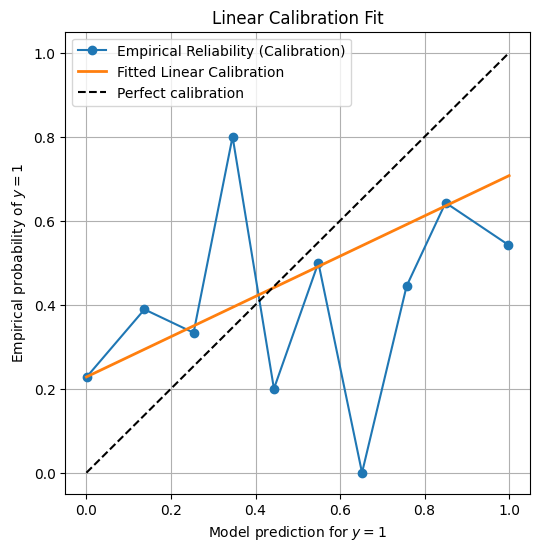

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities and true labels from the calibration set
cal_probs = nb.predict_proba(X_cal)[:, 1]   
cal_true  = y_cal                          


# --------------------------------------
# Fit linear calibration by solving LLS
# --------------------------------------

# Build design matrix of form [p, 1]
A = np.column_stack([cal_probs, np.ones_like(cal_probs)])

# Solve the LLS system to find best-fitting a and b
theta, _, _, _ = np.linalg.lstsq(A, cal_true, rcond=None)
a, b = theta[0], theta[1]

print(f"Fitted linear calibration parameters: a = {a:.4f}, b = {b:.4f}")


# ------------------------------------------------------------
# Apply fitted linear calibration mapping to new probabilities
# ------------------------------------------------------------
def apply_linear_calibration(probs, a, b):
    """ Apply the fitted linear calibration mapping to probability scores and clip the result to the valid range. """

    calibrated = a * probs + b
    return np.clip(calibrated, 0, 1)

# Apply calibration to calibration and test sets
cal_probs_lin  = apply_linear_calibration(cal_probs, a, b) 
test_probs_unc = nb.predict_proba(X_test)[:, 1]
test_probs_lin = apply_linear_calibration(test_probs_unc, a, b)


# ----------------------------------------------------
# Plot fitted line vs empirical reliability curve
# ----------------------------------------------------
# Define probability bins
n_bins = 10
bins = np.linspace(0,1,n_bins+1)

# Assign each predicted probability to one of the bin intervals
bin_ids = np.digitize(cal_probs, bins) - 1

# Store per-bin average predicted probabilities and fraction of true positives
avg_pred = []
frac_true = []

# For each bin compute statistics
for b_i in range(n_bins):

    # Boolean mask selecting all samples whose predicted prob falls in bin b
    in_bin = (bin_ids == b_i)

    # If no samples in bin
    if np.sum(in_bin) == 0:
        avg_pred.append(np.nan)
        frac_true.append(np.nan)
    
    # Otherwise compute the mean predicted probability and true fraction
    else:
        avg_pred.append(np.mean(cal_probs[in_bin]))
        frac_true.append(np.mean(cal_true[in_bin]))

avg_pred = np.array(avg_pred)
frac_true = np.array(frac_true)

# Plot
plt.figure(figsize=(6,6))
plt.plot(avg_pred, frac_true, 'o-', label="Empirical Reliability (Calibration)")

x_line = np.linspace(0,1,100)
plt.plot(x_line, apply_linear_calibration(x_line, a, b), label="Fitted Linear Calibration", linewidth=2)
plt.plot([0,1],[0,1],'k--', label="Perfect calibration")

x_line = np.linspace(0, 1, 5)
y_line = apply_linear_calibration(x_line, a, b)

plt.xlabel("Model prediction for $y = 1$")
plt.ylabel("Empirical probability of $y = 1$")
plt.title("Linear Calibration Fit")

plt.grid(True)
plt.legend()
plt.show()

#### D.1.2 – Platt Scaling

**Goal of this section:**  
Apply Platt scaling, which fits a logistic (sigmoid) transformation, $\hat{p}(x) = \sigma(A\,f(x) + B)$, to map uncalibrated model scores $f(x)$ into calibrated probabilities.

**What this code does:**
- Wraps the previously trained Naive Bayes model inside a `CalibratedClassifierCV`
- Uses the calibration split $(X_{\text{cal}},\, y_{\text{cal}})$ to fit the sigmoid parameters $A$ and $B$
- Produces calibrated probability estimates on the test set
- Stores both the fitted model and its calibrated test probabilities for later comparison

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

# Train sklearn Naive Bayes on the training set
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Apply Platt scaling (sigmoid)
cal_gnb_platt = CalibratedClassifierCV(gnb, method='sigmoid', cv="prefit")
cal_gnb_platt.fit(X_cal, y_cal)

# Get calibrated probabilities
test_probs_platt = cal_gnb_platt.predict_proba(X_test)[:, 1]

print("Platt scaling complete.")

Platt scaling complete.


/Users/kieransaphir/Desktop/Warwick/CS_Y3/CS342/coursework/cs342-cw/lib/python3.11/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
